In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
from summary_viewer import *
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
import itertools
from utils import *
from scipy.stats import skew, kurtosis
from analysis.weights import neuron_vocab_cosine_moments
from analysis.vocab_df import *
from analysis.neuron_df import *

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
model_name = 'stanford-gpt2-small-a'
model = HookedTransformer.from_pretrained(model_name)

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-small-a into HookedTransformer


In [4]:
models = ['pythia-160m', 'stanford-gpt2-small-a', 'stanford-gpt2-medium-a']
neuron_dfs = {}
for model_name in models:
    neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
    neuron_df['excess_corr'] = neuron_df['mean_corr'] - neuron_df['mean_baseline']
    neuron_df['is_universal'] = neuron_df.excess_corr > 0.5
    neuron_df['is_sparse'] = neuron_df.sparsity < 0.02
    neuron_dfs[model_name] = neuron_df

In [5]:
neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
neuron_df['excess_corr'] = neuron_df['mean_corr'] - neuron_df['mean_baseline']

In [7]:
#neuron_df.query('excess_corr > 0.5').to_csv('dataframes/interpretable_neurons/stanford-gpt2-medium-a/universal.csv', index=False)

In [12]:
main_display_cols = {
    'sparsity': 'act frequency',
    'mean': 'act mean',
    'skew': 'act skew',
    'kurt': 'act kurtosis',
    'input_bias': 'input bias',
    'in_out_sim': '$\cos(w_{in}, w_{out})$',
    'l2_penalty': '$L_2$ penalty',
    'vocab_kurt': '$W_U$ kurtosis',
}

In [13]:
from scipy.stats import percentileofscore


In [14]:
def compute_percentile(series):
    return series.transform(lambda x: percentileofscore(series, x))

def make_percentile_df(neuron_df, display_cols):
    percentile_df = neuron_df.set_index(['layer', 'neuron'])[display_cols.keys()
        ].groupby('layer').apply(lambda group: group.transform(compute_percentile))

    plot_df = percentile_df.reset_index().melt(
        id_vars=['layer', 'neuron'], 
        var_name='metric', value_name='value'
    )

    plot_df = plot_df.merge(
        neuron_df[['layer', 'neuron', 'is_universal']], 
        on=['layer', 'neuron']
    )
    return plot_df

In [15]:
plot_dfs = {
    model_name: make_percentile_df(neuron_df, main_display_cols) 
    for model_name, neuron_df in neuron_dfs.items()
}

In [16]:
plot_df = pd.concat(plot_dfs, names=['model']).reset_index().drop(columns=['level_1'])

/tmp/ipykernel_124216/1371196127.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([main_display_cols[x.get_text()] for x in ax.get_xticklabels()])


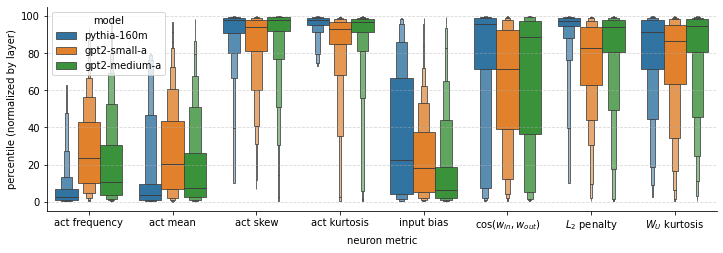

In [19]:
model_diplay_names = {
    'pythia-160m': 'pythia-160m', 
    'stanford-gpt2-small-a': 'gpt2-small-a', 
    'stanford-gpt2-medium-a': 'gpt2-medium-a'
}

fig, ax = plt.subplots(figsize=(12, 3.75))
sns.boxenplot(
    data=plot_df.query('is_universal'), 
    x='metric', y='value', hue='model', 
    showfliers=False, hue_order=model_diplay_names.keys(), ax=ax
)
# change x axis labels to use display_cols
ax.set_xticklabels([main_display_cols[x.get_text()] for x in ax.get_xticklabels()])
ax.set_ylabel('percentile (normalized by layer)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, model_diplay_names.values(), title='model')

# turn of top and right spines
sns.despine()
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=5)
ax.set_xlabel('neuron metric')

plt.savefig('figures/universal_neurons_prop.png', bbox_inches='tight', dpi=200)

In [18]:
plot_df.query('is_universal').query('metric == "sparsity"').model.value_counts()

stanford-gpt2-small-a     1533
stanford-gpt2-medium-a    1211
pythia-160m                465
Name: model, dtype: int64

In [34]:
# # OLD

# fig, ax = plt.subplots(figsize=(12, 4))
# sns.boxenplot(data=plot_df, x='metric', y='value', hue='is_universal', showfliers=False, hue_order=[True, False], ax=ax)
# # change x axis labels to use display_cols
# ax.set_xticklabels([main_display_cols[x.get_text()] for x in ax.get_xticklabels()])
# ax.set_ylabel('universal neuron percentiles (within layer)')

# # change legend labels to "Universal" and "not" with no title
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, ['universal', 'not'], title='Neuron')

# # turn of top and right spines
# sns.despine()
# ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=5)
# ax.set_xlabel('neuron metric')
# ax.set_title('gpt2-small-a')

In [22]:
appendix_display_cols = {
    # 'input_bias': 'input bias',
    'vocab_kurt': '$W_U$ kurtosis',
    'vocab_skew': '$W_U$ skew',
    'in_out_sim': '$\cos(w_{in}, w_{out})$',
    'l2_penalty': '$L_2$ penalty',
    'sparsity': 'act sparsity',
    'skew': 'act skew',
    'kurt': 'act kurtosis',
}

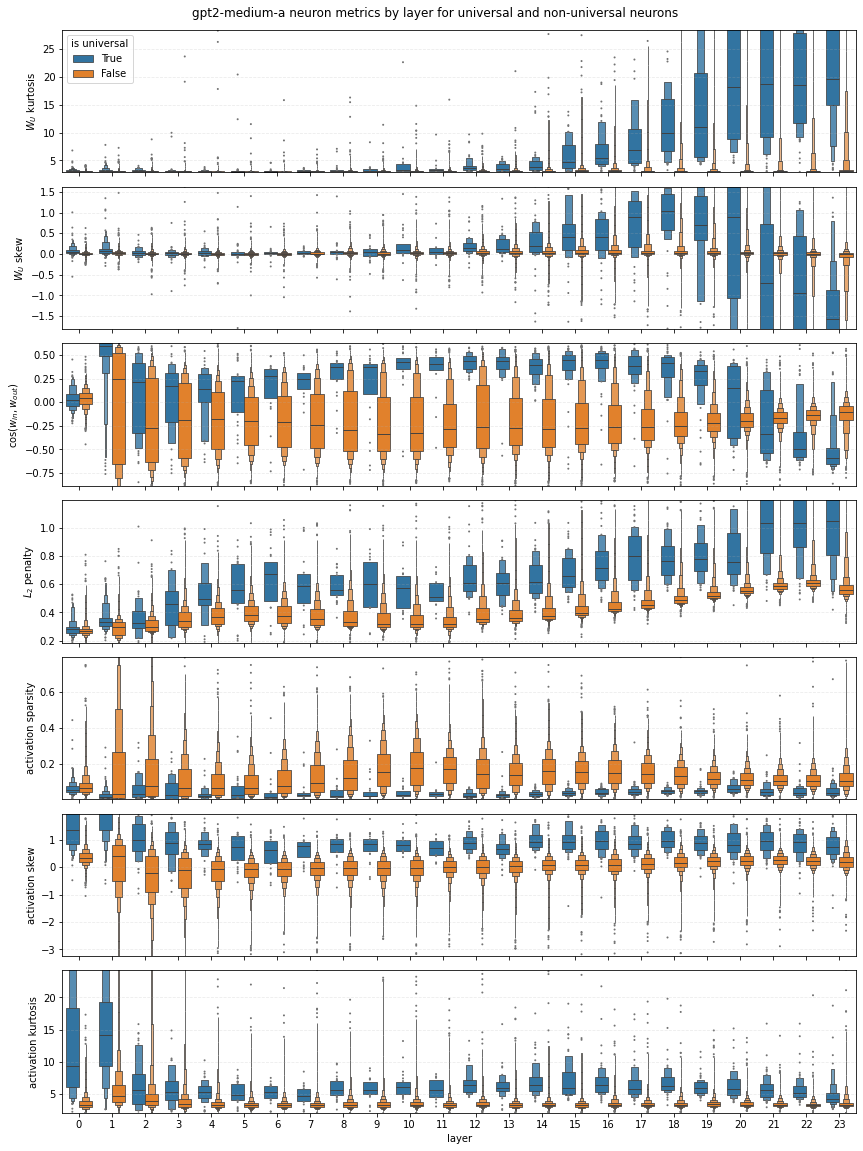

In [28]:
percentile_cutoff = 0.25

fig, axs = plt.subplots(len(appendix_display_cols), 1, figsize=(12, 2.3 * len(appendix_display_cols)), sharex=True)

for ax, (metric, display_name) in zip(axs, appendix_display_cols.items()):
    sns.boxenplot(data=neuron_df, x='layer', y=metric, showfliers=True, ax=ax, hue='is_universal', hue_order=[True, False], flier_kws={'s': 1})
    ax.set_ylabel(display_name.replace('act', 'activation'))
    lb = np.percentile(neuron_df[metric], percentile_cutoff)
    ub = np.percentile(neuron_df[metric], 100-percentile_cutoff)
    ax.set_ylim(lb, ub)
    ax.grid(axis='y', linestyle='--', alpha=0.25, zorder=5)
    # only first plot gets legend
    if ax == axs[0]:
        ax.legend(title='is universal', loc='upper left')
    else:
        ax.get_legend().remove()

ax.set_xlabel('layer')

plt.suptitle('gpt2-medium-a neuron metrics by layer for universal and non-universal neurons', y=0.99)
plt.tight_layout()

fig.savefig('figures/appendix_neuron_metrics_by_layer.png', dpi=100, bbox_inches='tight')

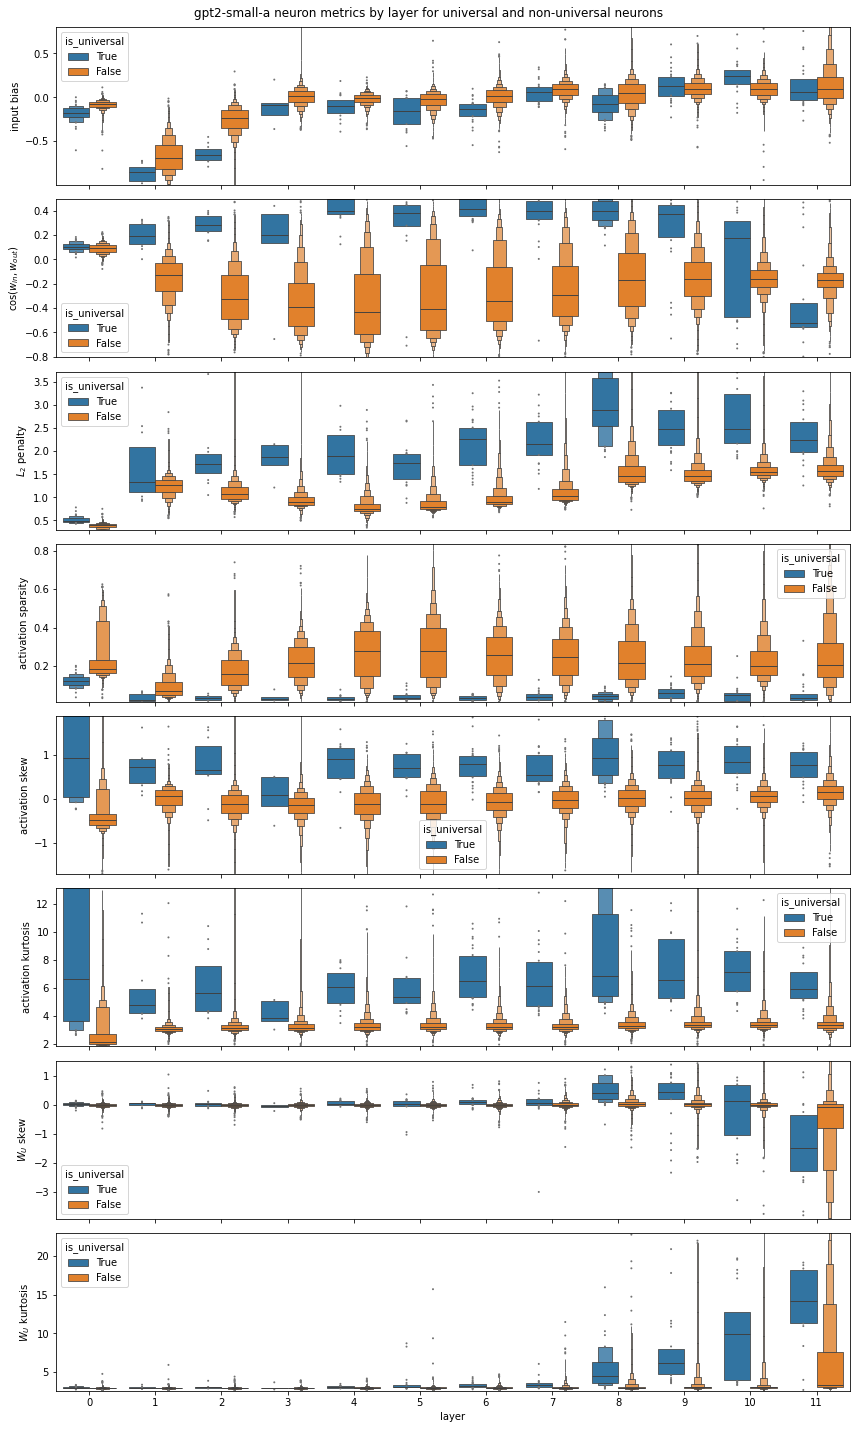

In [36]:
percentile_cutoff = 0.25

fig, axs = plt.subplots(len(appendix_display_cols), 1, figsize=(12, 2.5 * len(appendix_display_cols)), sharex=True)

for ax, (metric, display_name) in zip(axs, appendix_display_cols.items()):
    sns.boxenplot(data=df, x='layer', y=metric, showfliers=True, ax=ax, hue='is_universal', hue_order=[True, False], flier_kws={'s': 1}, outlier_prop=0.005)
    ax.set_ylabel(display_name.replace('act', 'activation'))
    lb = np.percentile(df[metric], percentile_cutoff)
    ub = np.percentile(df[metric], 100-percentile_cutoff)
    ax.set_ylim(lb, ub)

ax.set_xlabel('layer')

plt.suptitle('gpt2-small-a neuron metrics by layer for universal and non-universal neurons', y=0.99)
plt.tight_layout()

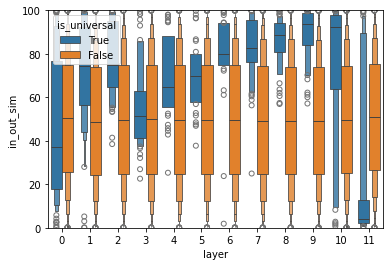

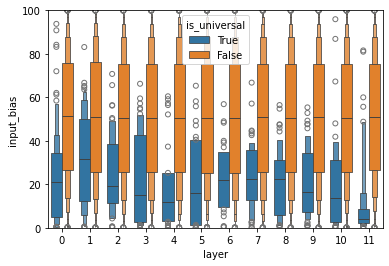

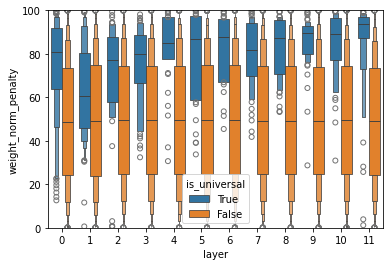

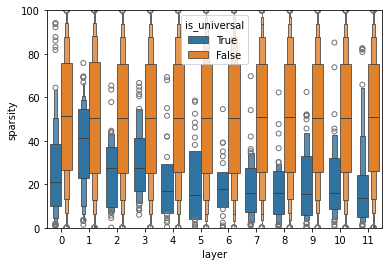

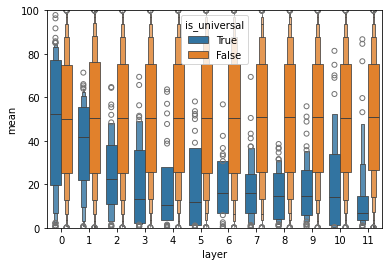

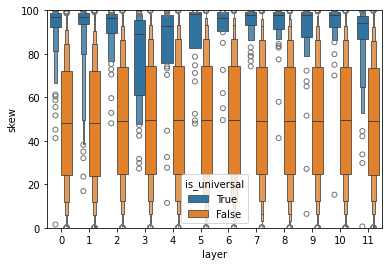

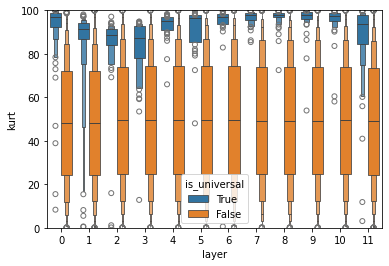

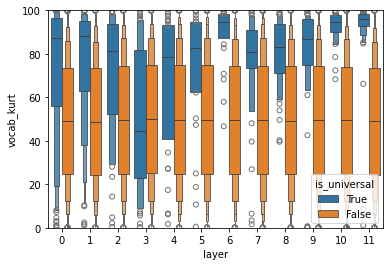

In [22]:
cols = percentile_df.reset_index().columns[2:-1]
for col in cols:
    sns.boxenplot(x='layer', y=col, data=percentile_df, hue='is_universal', hue_order=[True, False])
    # change ylim to be 99 percentile
    #lb = np.percentile(df[col], 0.1)
    #ub = np.percentile(df[col], 99.9)
    plt.ylim(0, 100)
    plt.show()

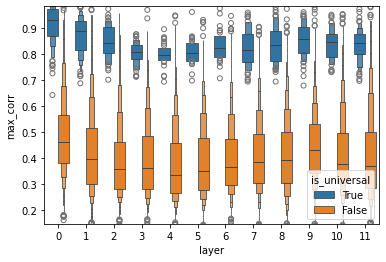

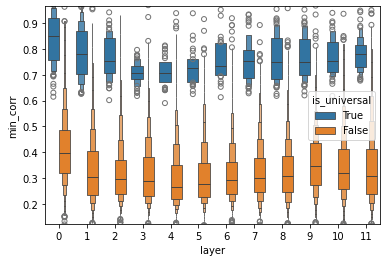

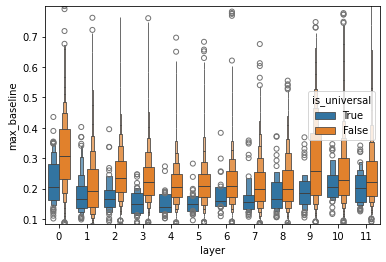

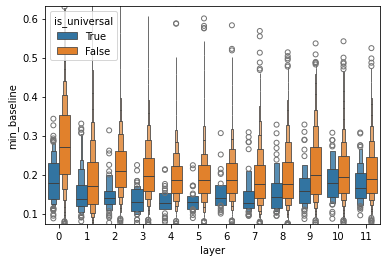

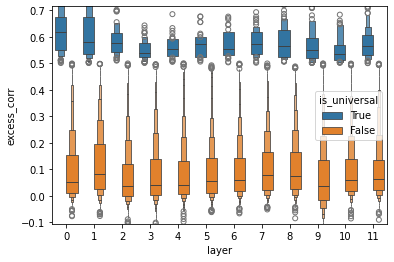

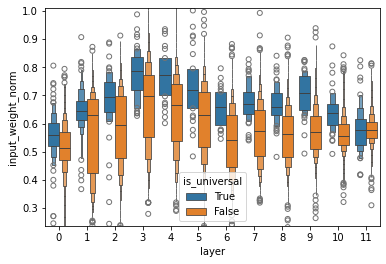

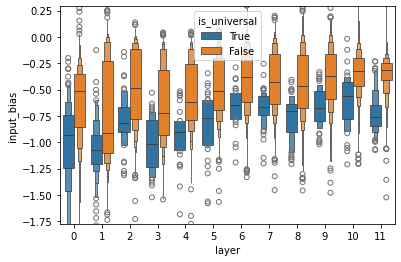

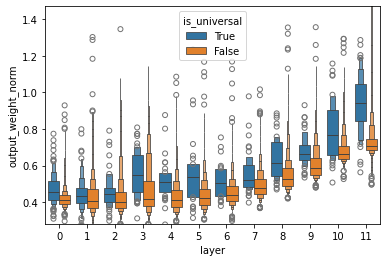

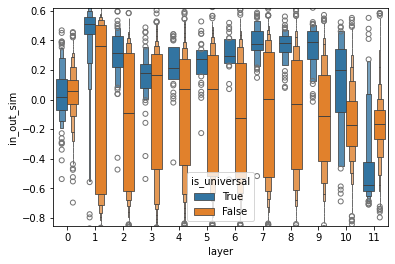

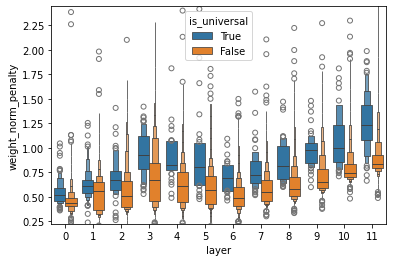

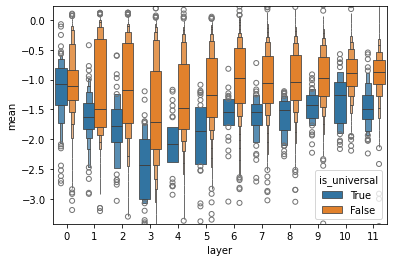

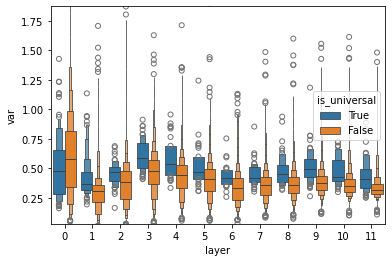

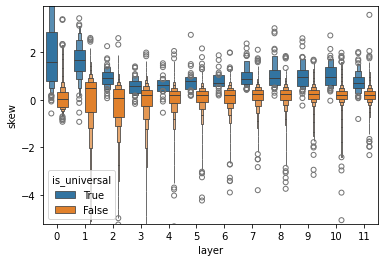

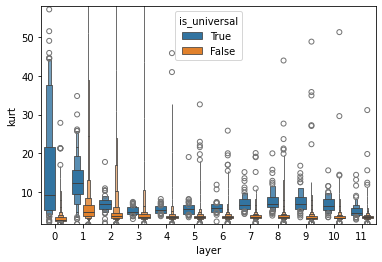

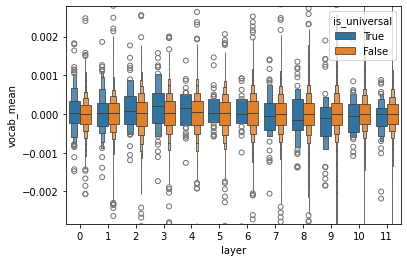

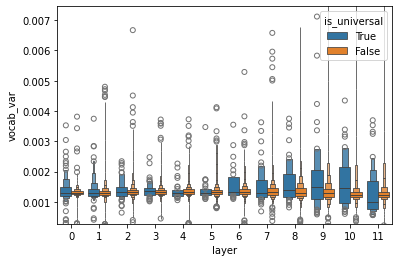

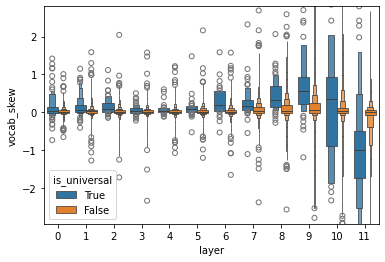

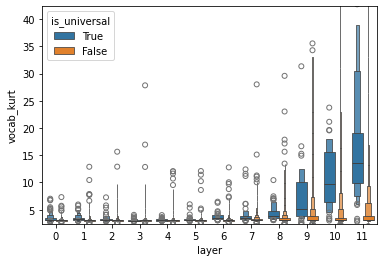

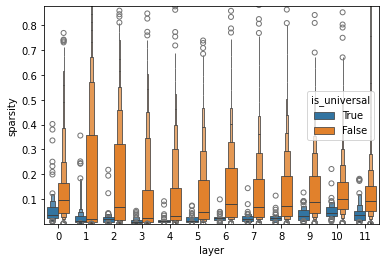

In [8]:
cols = df.columns[2:-2]
for col in cols:
    sns.boxenplot(x='layer', y=col, data=df, hue='is_universal', hue_order=[True, False])
    # change ylim to be 99 percentile
    lb = np.percentile(df[col], 0.1)
    ub = np.percentile(df[col], 99.9)
    plt.ylim(lb, ub)
    plt.show()